In [1]:
import pandas as pd

In [7]:
target = 'vacc_h1n1_f'
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')

In [8]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, train_size=0.80, test_size=0.20,
                                stratify=train[target], random_state=2)
train.shape, val.shape, test.shape

((33723, 39), (8431, 39), (28104, 38))

In [9]:
def engineer(df):
    behaviorals = [col for col in df.columns if 'behavioral' in col]
    df['behaviorals'] = df[behaviorals].sum(axis=1)

    dels = [col for col in df.columns if('employment' in col or 'seas' in col)]

    return df

train = engineer(train)
val = engineer(train)
test = engineer(test)

In [10]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [13]:
%%time
from category_encoders import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
)

pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))

검증 정확도:  0.9977166918720162
Wall time: 3.44 s


In [16]:
pipe.named_steps['randomforestclassifier'].oob_score_

0.8219316193695697

In [19]:
from category_encoders import OrdinalEncoder
enc = OrdinalEncoder(handle_missing="value")
X = [['Male', 1, 'Yes'], ['Female', 3, 'No'], ['Female', 2, 'None']]
enc.fit(X)

OrdinalEncoder(cols=[0, 2],
               mapping=[{'col': 0, 'data_type': dtype('O'),
                         'mapping': Male      1
Female    2
NaN      -2
dtype: int64},
                        {'col': 2, 'data_type': dtype('O'),
                         'mapping': Yes     1
No      2
None    3
NaN    -2
dtype: int64}])

In [21]:
enc.transform([['Male',1,'No'],['Female', 10]])

,0,1,2
0,1,1,2
1,2,10,-2


In [22]:
enc.category_mapping

[{'col': 0,
  'mapping': Male      1
  Female    2
  NaN      -2
  dtype: int64,
  'data_type': dtype('O')},
 {'col': 2,
  'mapping': Yes     1
  No      2
  None    3
  NaN    -2
  dtype: int64,
  'data_type': dtype('O')}]

In [23]:
%%time

pipe_ord = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=10, n_jobs=-1, oob_score=True)
)

pipe_ord.fit(X_train, y_train)
print('검정 정확도', pipe_ord.score(X_val, y_val))

검정 정확도 0.9977166918720162
Wall time: 1.43 s


In [24]:
print('Shape before: ',X_train.shape)

enc = pipe.named_steps['onehotencoder']
encoded = enc.transform(X_train)
print('OneHot shae:',encoded.shape)

enc = pipe_ord.named_steps['ordinalencoder']
encoded = enc.transform(X_train)
print('Ordinal shape:',encoded.shape)

Shape before:  (33723, 39)
OneHot shae: (33723, 184)
Ordinal shape: (33723, 39)


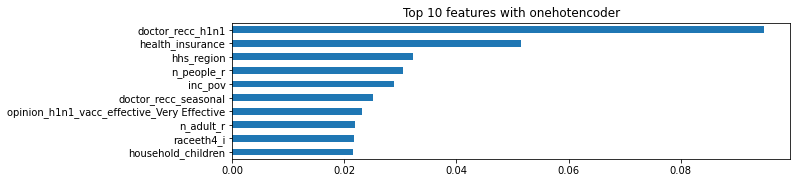

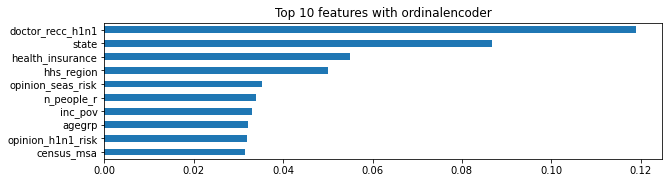

In [27]:
import matplotlib.pyplot as plt

rf = pipe.named_steps['randomforestclassifier']
colnames = pipe.named_steps['onehotencoder'].get_feature_names()
importances = pd.Series(rf.feature_importances_, colnames)

n = 10
plt.figure(figsize = (10,n/4))
plt.title(f'Top {n} features with onehotencoder')
importances.sort_values()[-n:].plot.barh();

rf_ord = pipe_ord.named_steps['randomforestclassifier']
importances_ord = pd.Series(rf_ord.feature_importances_, X_train.columns)

plt.figure(figsize=(10,n/4))
plt.title(f'Top {n} features with ordinalencoder')
importances_ord.sort_values()[-n:].plot.barh();

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

pipe_lr = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    LogisticRegression(n_jobs=-1)
)

pipe_lr.fit(X_train, y_train)
print('검증세트 정확도 ',pipe_lr.score(X_val,y_val))

검증세트 정확도  0.8160009489072739


In [29]:
pipe_lr = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    LogisticRegression(n_jobs=-1)
)

pipe_lr.fit(X_train, y_train)

print('검증세트 정확도 ',pipe_lr.score(X_val,y_val))

검증세트 정확도  0.8003439788868132


In [30]:
columns = ['mobility', 'density']
data = [[80.574, -3.067]
,[84.248, -2.981]
,[87.264, -2.921]
,[87.195, -2.912]
,[89.076, -2.84]
,[89.608, -2.797]
,[89.868, -2.702]
,[90.101, -2.699]
,[92.405, -2.633]
,[95.854, -2.481]
,[100.696, -2.363]
,[101.06, -2.322]
,[401.672, -1.501]
,[390.724, -1.46]
,[567.534, -1.274]
,[635.316, -1.212]
,[733.054, -1.1]
,[759.087, -1.046]
,[894.206, -0.915]
,[990.785, -0.714]
,[1090.109, -0.566]
,[1080.914, -0.545]
,[1122.643, -0.4]
,[1178.351, -0.309]
,[1260.531, -0.109]
,[1273.514, -0.103]
,[1288.339, 0.01]
,[1327.543, 0.119]
,[1353.863, 0.377]
,[1414.509, 0.79]
,[1425.208, 0.963]
,[1421.384, 1.006]
,[1442.962, 1.115]
,[1464.35, 1.572]
,[1468.705, 1.841]
,[1447.894, 2.047]
,[1457.628, 2.2]]

thurber = pd.DataFrame(columns=columns, data=data)
X_thurber = thurber[['mobility']]
y_thurber = thurber['density']

interactive(children=(IntSlider(value=1, description='max_depth', max=10, min=1), IntSlider(value=10, descript…

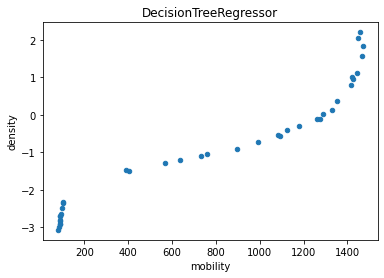

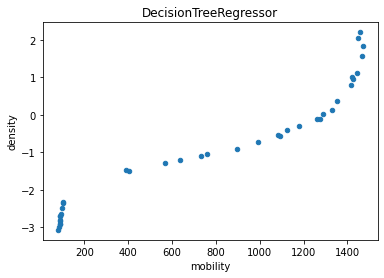

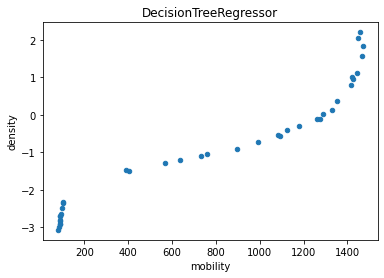

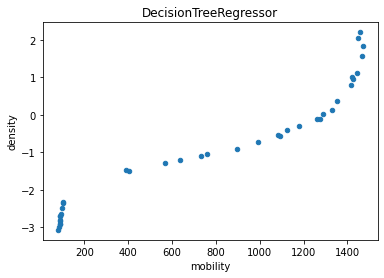

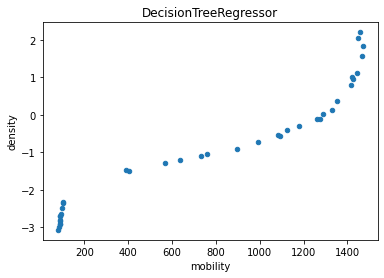

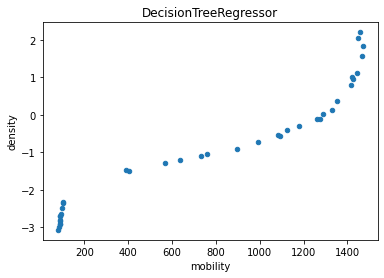

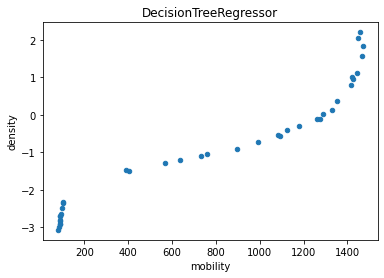

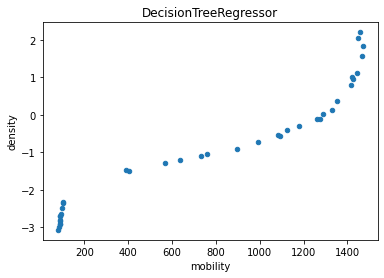

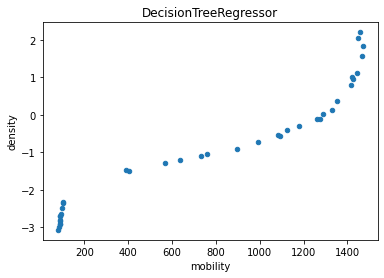

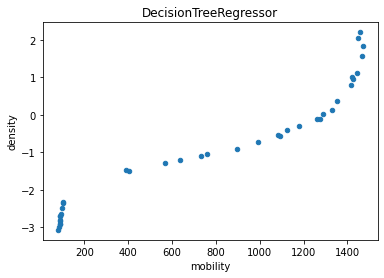

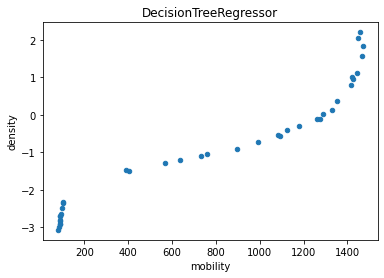

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

def trees(max_depth=1, n_estimators=1):
    models = [DecisionTreeRegressor(max_depth=max_depth),
              RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators)]
    
    for model in models:
        name = model.__class__.__name__
        model.fit(X_thurber, y_thurber)
        ax = thurber.plot('mobility','density', kind='scatter', title=name)
        ax.step(X_thurber, model.predict(X_thurber), where='mid')
        plt.show()
    
interact(trees, max_depth=(1,10,1), n_estimators=(10,50,10));